In [48]:
import pickle
import numpy as np
import xgboost as xgb

np.random.seed(2026)

# Define median-based ensemble of surrogates
class medClassifier:
    def __init__(self, classifiers=None):
        self.classifiers = classifiers

    def predict(self, X):
        self.predictions_ = list()
        for classifier in self.classifiers:
            try:
                self.predictions_.append(classifier.predict(X)) #used for the random forest that is part of the ensemble
            except:
                X = xgb.DMatrix(X)
                self.predictions_.append(classifier.predict(X)) #used for the XGBoost models that are part of the ensemble
        med1 = np.median(self.predictions_, axis=0) #median of predictions
        mean1 = np.mean(self.predictions_, axis=0) #mean of predictions
        out = med1 + np.random.rand()*np.abs(med1-mean1) #add more noise if median is far from mean, indicating more uncertainty, also all noise is positive to focus on minimizing parts with more certainty
        return

# Define median-based ensemble of surrogates
class medClassifier:
    def __init__(self, classifiers=None):
        self.classifiers = classifiers

    def predict(self, X):
        self.predictions_ = list()
        for classifier in self.classifiers:
            try:
                self.predictions_.append(classifier.predict(X)) #used for the random forest that is part of the ensemble
            except:
                X = xgb.DMatrix(X)
                self.predictions_.append(classifier.predict(X)) #used for the XGBoost models that are part of the ensemble
        med1 = np.median(self.predictions_, axis=0) #median of predictions
        mean1 = np.mean(self.predictions_, axis=0) #mean of predictions
        out = med1 + np.random.rand()*np.abs(med1-mean1) #add more noise if median is far from mean, indicating more uncertainty, also all noise is positive to focus on minimizing parts with more certainty
        return out

# Load Ensemble
#Ensemblefile = os.path.join(folder_path,"Ensemble.pkl")
Ensemblefile = "Ensemble.pkl"
with open(Ensemblefile, 'rb') as file:
    Ensemble = pickle.load(file)


#This is the first objective function
def objective1(x):
    x = np.array([x])
    pred = Ensemble.predict(x)
    return pred[0]

from scipy.stats import truncnorm

# Build second objective
rotor_diameter = 126 # in meters
farm_length = 333.33*5 # in meters

def objective2(x):

    x = np.array([x])
    coords = np.resize(x,(2,5)) # wind turbine coordinates

    # Use a Monte Carlo simulation for the birds, who all fly from top to bottom at an x-location with a normal distribution. The mean of the normal distribution is far to the left of the wind farm.
    bird_mean = -25000 #width of bird corridor is 50km
    x_sigma = 4 # assume this many sigma of birds to stay within the planned corridor
    bird_std = (25000/x_sigma)
    #simulate birds (location in meters)
    nr_birds = 1000 # number of birds
    birds = truncnorm.rvs(x_sigma,
                          x_sigma+farm_length/bird_std,
                          loc=bird_mean,
                          scale=bird_std,
                          size=nr_birds,
                          random_state=2026 # fix the random seed
    ) # Uses a truncated normal distribution, only sampling in the wind farm, not the entire bird corridor

    #check how many birds are close to a wind turbine (everything right of the leftmost turbine - rotor_diameter is dangerous area)
    leftmost = np.min(coords[0]) #location of leftmost turbine, in [0,1] units
    leftmost = leftmost*farm_length #change to meters
    threshold = leftmost-rotor_diameter #threshold of where the dangerous area starts (from left to right)

    close_birds = np.sum(birds >= threshold)/nr_birds #check how many birds fly to the right of the threshold
    return close_birds

# Build the constraint

from scipy.spatial.distance import cdist

def constraint1(x):
    coords = np.resize(x,(5,2))
    min_dist = 999999 #minimum distance between turbines (Euclidean)

    for turb in range(4):
        dists = cdist([coords[turb]],coords[turb+1:])
        next_min = np.min(dists)
        if next_min < min_dist:
            min_dist = next_min
    # if min_dist*farm_length < 2*rotor_diameter:
    #     constr = 0 # constraint not satisfied, wind turbines are too close to each other
    # else:
    #     constr = 1 # constraint satisfied
    
    cv = 2*rotor_diameter - min_dist*farm_length # constraint violation: <=0 is feasible and >0 is infeasible
    
    return cv

In [49]:
# test objectives and constraints
x3 = x1 = [0.29, 0.4871309875290023, 0.54153605985017246, 0.2954912222384124, 0.9558389075666868, 0.1992480932223422, 0.5400992985215289, 0.14902261675540462, 0.7592757901802544, 0.9586]
print(objective1(x3))
print(objective2(x3))
print(constraint1(x3))

-50.14358
0.709
7.876354330066846


feasible_rate = 0.498 (249/500)


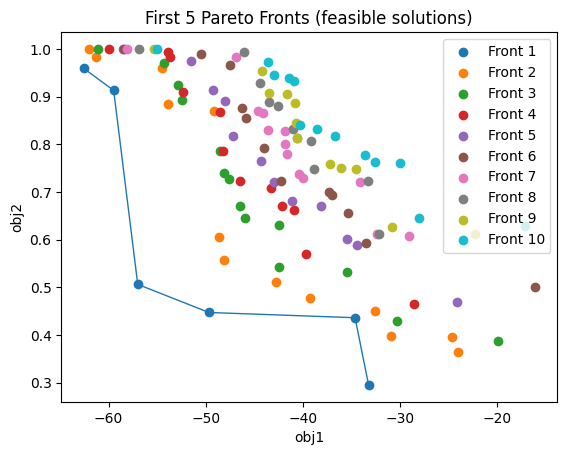

In [52]:
# -------------------------
# Random search (simple)
# -------------------------
import pandas as pd
N_EVAL = 500
DIM = 10  # 5 turbines * 2 coords

rows = []
for i in range(N_EVAL):
    x = np.random.rand(DIM)  # sample in [0,1]^10

    f1 = objective1(x)
    f2 = objective2(x)
    cv = constraint1(x)
    feasible = (cv <= 0)

    rows.append([f1, f2, cv, int(feasible)])

df = pd.DataFrame(rows, columns=["obj1", "obj2", "cv", "feasible"])
df.to_csv("random_search_results.csv", index=False)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

df = pd.read_csv("random_search_results.csv")

feasible_rate = df["feasible"].mean()
print("feasible_rate =", feasible_rate, f"({df['feasible'].sum()}/{len(df)})")

feas = df[df["feasible"] == 1].copy()

if len(feas) == 0:
    print("No feasible solutions -> cannot compute Pareto fronts.")
else:
    F = feas[["obj1", "obj2"]].to_numpy()

    nds = NonDominatedSorting()
    fronts = nds.do(F)

    plt.figure()

    MAX_FRONTS = 10
    for i, front in enumerate(fronts[:MAX_FRONTS]):
        pts = F[front]
        plt.scatter(pts[:, 0], pts[:, 1], label=f"Front {i+1}")

    # connect best front with line
    best = F[fronts[0]]
    best = best[np.argsort(best[:, 0])]
    plt.plot(best[:, 0], best[:, 1], linewidth=1)

    plt.xlabel("obj1")
    plt.ylabel("obj2")
    plt.title("First 5 Pareto Fronts (feasible solutions)")
    plt.legend()
    plt.savefig("pareto_fronts_RS.png", dpi=300, bbox_inches="tight")
    plt.show()

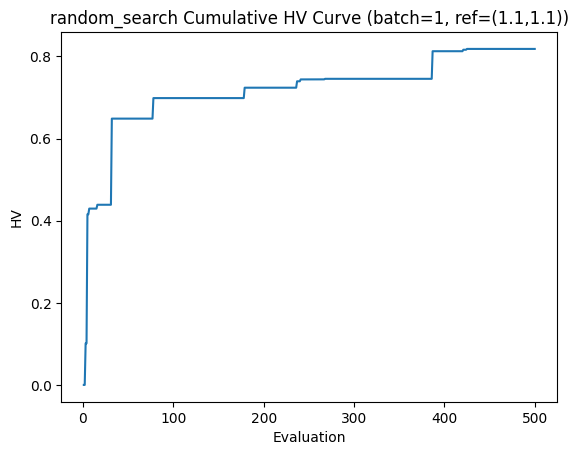

Saved: hv_curve_random_search_cumulative.png


In [55]:
import matplotlib.pyplot as plt

from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.indicators.hv import HV

CSV_PATH = "random_search_results.csv"
BATCH_SIZE = 1
REF_POINT = np.array([1.1, 1.1], dtype=float)

df = pd.read_csv(CSV_PATH)

f_min = np.array([-67.83963013,   0.153], dtype=float)
f_max = np.array([-0.77212131,  1.0], dtype=float)

denom = f_max - f_min
denom[denom == 0] = 1.0

hv_indicator = HV(ref_point=REF_POINT)

xs, hvs = [], []

n = len(df)
for end in range(BATCH_SIZE, n + 1, BATCH_SIZE):
    cur = df.iloc[:end]
    cur_feas = cur[cur["feasible"] == 1]

    xs.append(end)

    if len(cur_feas) == 0:
        hvs.append(0.0)
        continue

    F = cur_feas[["obj1", "obj2"]].to_numpy(dtype=float)

    fronts = NonDominatedSorting().do(F)
    F_best = F[fronts[0]]

    F_best_norm = (F_best - f_min) / denom

    hv_value = float(hv_indicator(F_best_norm))
    hvs.append(hv_value)

if n % BATCH_SIZE != 0:
    end = n
    cur = df.iloc[:end]
    cur_feas = cur[cur["feasible"] == 1]
    xs.append(end)

    if len(cur_feas) == 0:
        hvs.append(0.0)
    else:
        F = cur_feas[["obj1", "obj2"]].to_numpy(dtype=float)
        fronts = NonDominatedSorting().do(F)
        F_best = F[fronts[0]]
        F_best_norm = (F_best - f_min) / denom
        hvs.append(float(hv_indicator(F_best_norm)))

plt.figure()
plt.plot(xs, hvs)
plt.xlabel("Evaluation")
plt.ylabel("HV")
plt.title(f"random_search Cumulative HV Curve (batch={BATCH_SIZE}, ref=(1.1,1.1))")
plt.savefig("hv_curve_random_search_cumulative.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved: hv_curve_random_search_cumulative.png")